# Map Uniprot IDs to gene symbols

In [39]:
import polars as pl
import pandas as pd
from biomart import BiomartServer
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ids = pl.read_csv("./inputs/proteomics_data/protein_metadata.txt", separator="\t")
uniprot_ids = ids.select("uniprot_id").to_series().unique().to_list()

In [76]:
# Connect to the BioMart server and dataset
server = BiomartServer("http://www.ensembl.org/biomart/martservice")
mart = server.datasets['hsapiens_gene_ensembl']

# Define the attributes to retrieve
attributes = [
    'uniprotswissprot',     # UniProt ID (SwissProt)
    'external_gene_name',   # Gene symbol
    'ensembl_gene_id'       # Optional: Ensembl Gene ID
]

batch_size = 100
results = []

# Query BioMart in batches
for i in range(0, len(uniprot_ids), batch_size):
    batch = uniprot_ids[i:i + batch_size]
    
    filters = {
        'uniprotswissprot': batch
    }
    
    try:
        response = mart.search({"attributes": attributes, "filters": filters})
        data = [line.decode("utf-8").split("\t") for line in response.iter_lines()]
        df_batch = pl.DataFrame(pd.DataFrame(data))
        df_batch.columns = ["uniprot_id", "gene_symbol", "ensembl_gene_id"]
        results.append(df_batch)
    except Exception as e:
        print(f"Batch {i//batch_size + 1} failed: {e}")

# Combine all results
all_gene_symbols = pl.concat(results)

In [77]:
unique_gene_symbols = all_gene_symbols.unique(subset=["uniprot_id"], keep="first")
ids = ids.join(unique_gene_symbols, on="uniprot_id", how="left")
ids.write_csv("./outputs/gene_ids.csv")

# NOTE: we looked for interesting patterns in these proteins by uploading them to enrichr

## Get subcellular locations from Human Protein Atlas

In [78]:
hpa = pl.DataFrame(pd.read_table("./inputs/external_annotations/hpa_subcellular_location.tsv", sep="\t")).rename({
    "Gene": "ensembl_gene_id"
})
hpa = ids.join(hpa, on="ensembl_gene_id", how="left")
hpa.write_csv("./outputs/proteins_hpa.csv")

## Determine which proteins are expressed in HepaRG

In [79]:
# Process data
counts = pl.read_csv("./inputs/external_transcriptomics/GSE288929_httr_atlas_counts.csv")

probes = pl.read_csv("./inputs/external_transcriptomics/GSE288929_httr_atlas_probes.csv").select([
    "Probe_Name", "Ensembl_Gene"
]).rename({"Ensembl_Gene": "ensembl_gene_id", "Probe_Name": "Probe_ID"})

meta = pl.read_csv("./inputs/external_transcriptomics/metadata.csv").with_columns(
    pl.concat_str(["Plate", "Well"], separator="_").alias("Sample_ID")
)

# Annotate counts with Ensembl gene ids
counts = counts.join(probes, on="Probe_ID").drop("Probe_ID")

In [80]:
heparg_samples = meta.filter(pl.col("Cell_line") == "HepaRG").select("Sample_ID").to_series().to_list()

In [84]:
heparg_counts = counts.select(["ensembl_gene_id"] + heparg_samples).filter(~pl.col("ensembl_gene_id").is_null())
heparg_counts = heparg_counts.filter(pl.col("ensembl_gene_id").is_in(ids.select("ensembl_gene_id").to_series().to_list()))
heparg_counts = (
    heparg_counts.group_by("ensembl_gene_id")
    .mean()
    .sort("ensembl_gene_id")
)

In [82]:
heparg_stats = heparg_counts.unpivot(
    index = "ensembl_gene_id"
).group_by("ensembl_gene_id").agg([
    pl.col("value").mean().alias("mean_counts"),
    pl.col("value").std().alias("std_counts")
]).sort("mean_counts", descending=True)

heparg_stats.write_csv("./outputs/nomics_mrna_counts.csv")

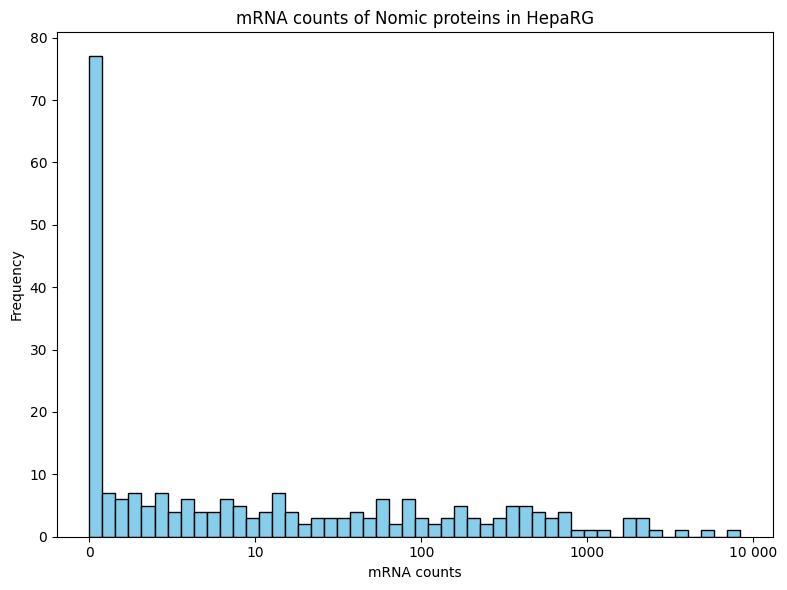

In [ ]:
tick_dict = {
    0: '0',
    1: '10',
    2: '100',
    3: '1000',
    4: '10 000',
}

log10_counts = np.log10(heparg_stats.select("mean_counts").to_numpy() + 1)
plt.figure(figsize=(8, 6))
plt.hist(log10_counts, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("mRNA counts")
plt.ylabel("Frequency")
plt.title("mRNA counts of Nomic proteins in HepaRG")

current_ticks = plt.gca().get_xticks()
major_ticks = [tick for tick in current_ticks if tick in tick_dict]
plt.xticks(major_ticks, [tick_dict.get(int(tick), str(int(tick))) for tick in major_ticks])

plt.tight_layout()
plt.show()

## Compare to raw concentration measurements

In [65]:
heparg_stats = pl.read_csv("./outputs/nomics_mrna_counts.csv")
gene_ids = pl.read_csv("./outputs/gene_ids.csv")
prot_conc = pl.read_csv("./inputs/proteomics_data/raw_concentration.csv", ignore_errors=True)

meta_cols = [i for i in prot_conc.columns if "Metadata" in i]
drop_cols = [i for i in meta_cols if i not in ["Metadata_plate_barcode", "Metadata_well_id"]]
prot_conc = prot_conc.filter(pl.col("Metadata_Compound") == "DMSO").drop(drop_cols).unpivot(
    index=["Metadata_plate_barcode", "Metadata_well_id"],
    variable_name="uniprot_id",
    value_name="concentration"
)

num_conc = (
    prot_conc.filter(~pl.col("concentration").str.contains("ULOD|LLOD")).with_columns(
        pl.col("concentration").cast(pl.Float64).alias("concentration_numeric")
    )
    .drop("concentration")
)

max_conc = (
    num_conc
    .group_by("uniprot_id")
    .agg([pl.col("concentration_numeric").max().alias("max_concentration")])
)


In [66]:

prot_conc = prot_conc.join(max_conc, on="uniprot_id", how="left")
prot_conc = prot_conc.join(num_conc, on=["Metadata_plate_barcode", "Metadata_well_id", "uniprot_id"], how="left")


In [67]:

prot_conc = prot_conc.with_columns(
    pl.when(pl.col("concentration") == "<LLOD").then(pl.lit(0))
    .when(pl.col("concentration") == ">ULOD").then(pl.col("max_concentration"))
    .otherwise(pl.col("concentration_numeric"))
    .alias("imputed_conc")
).drop([
    "max_concentration", "concentration_numeric"
])

prot_conc = prot_conc.join(gene_ids, on="uniprot_id").join(heparg_stats, on="ensembl_gene_id")

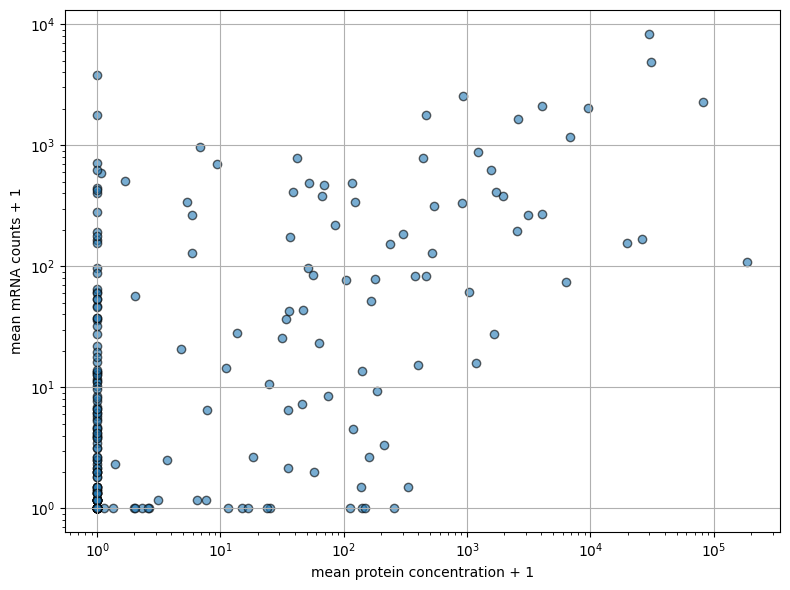

In [70]:
import matplotlib.pyplot as plt

# Convert to pandas for plotting
df = prot_conc.select(["gene_symbol", "mean_counts", "imputed_conc"]).group_by("gene_symbol").agg([
    pl.col("mean_counts").mean().alias("mean_counts"),
    pl.col("imputed_conc").mean().alias("mean_conc"),
])

df = df.with_columns(
    (pl.col("mean_counts") + 1).alias("mean_counts"),
    (pl.col("mean_conc") + 1).alias("mean_conc"),
).to_pandas()

# Create scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(df["mean_conc"], df["mean_counts"], alpha=0.6, edgecolor="k")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("mean protein concentration + 1")
plt.ylabel("mean mRNA counts + 1")
plt.grid(True)
plt.tight_layout()
plt.show()


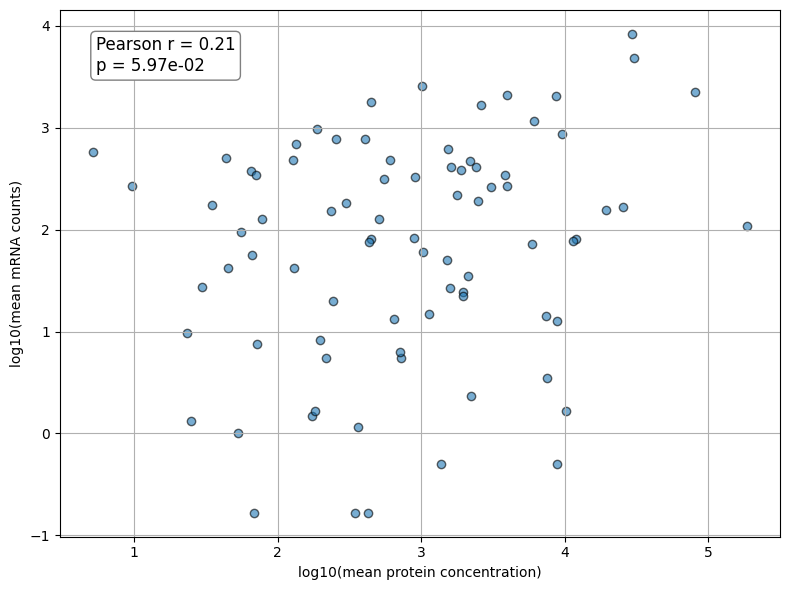

In [71]:
from scipy.stats import pearsonr

# calculate correlation between non-zero 
df = prot_conc.select(["gene_symbol", "mean_counts", "imputed_conc"]).drop_nulls().filter(pl.col("mean_counts") > 0).filter(pl.col("imputed_conc") > 0).with_columns(
    pl.col("mean_counts").log10().alias("log10_counts"),
    pl.col("imputed_conc").log10().alias("log10_conc")
).group_by("gene_symbol").agg([
    pl.col("log10_counts").mean().alias("log10_counts"),
    pl.col("log10_conc").mean().alias("log10_conc"),
]).to_pandas()

r, p = pearsonr(df["log10_conc"], df["log10_counts"])

plt.figure(figsize=(8, 6))
plt.scatter(df["log10_conc"], df["log10_counts"], alpha=0.6, edgecolor="k")

plt.xlabel("log10(mean protein concentration)")
plt.ylabel("log10(mean mRNA counts)")
plt.grid(True)

plt.text(0.05, 0.95, f"Pearson r = {r:.2f}\np = {p:.2e}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", fc="w", ec="0.5"))

         
plt.tight_layout()
plt.show()

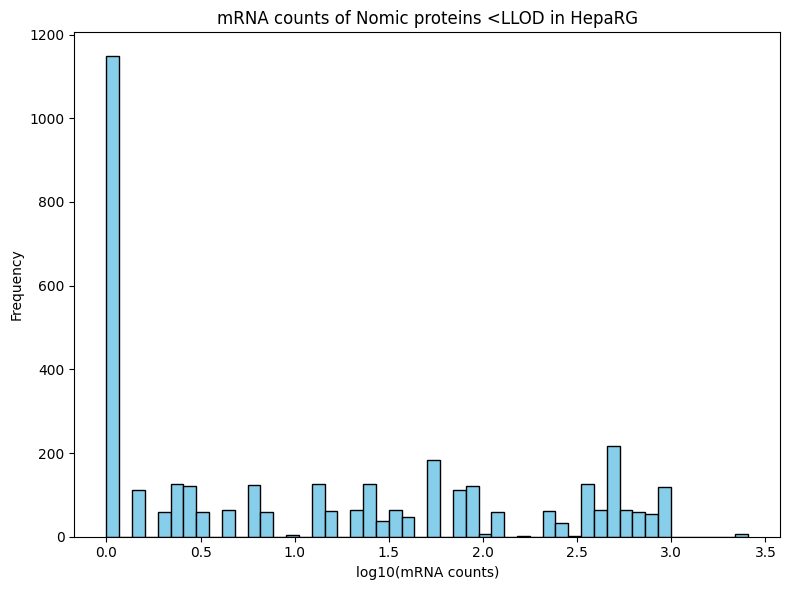

In [ ]:
df = prot_conc.filter(pl.col("imputed_conc") == 0)

log10_counts = np.log10(df.select("mean_counts").to_numpy() + 1)
plt.figure(figsize=(8, 6))
plt.hist(log10_counts, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("log10(mRNA counts)")
plt.ylabel("Frequency")
plt.title("mRNA counts of Nomic proteins <LLOD in HepaRG")

plt.tight_layout()
plt.show()

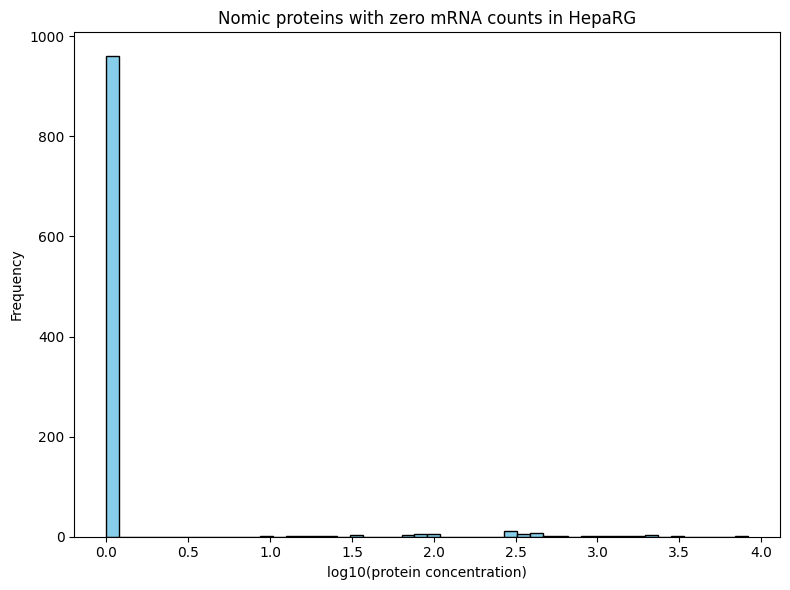

In [45]:
df = prot_conc.filter(pl.col("mean_counts") == 0)

log10_counts = np.log10(df.select("imputed_conc").to_numpy() + 1)
plt.figure(figsize=(8, 6))
plt.hist(log10_counts, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("log10(protein concentration)")
plt.ylabel("Frequency")
plt.title("Nomic proteins with zero mRNA counts in HepaRG")

plt.tight_layout()
plt.show()